# 批量归一化
从零实现

In [4]:
import torch 
from torch import nn
from d2l import torch as d2l


In [5]:
# moving ----- > 整个数据集的均值和方差
#eps --- > 防止出零
#momentum = 0.9 --- > 用来更新moving
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # 做inference
    if not torch.is_grad_enabled():
        # 全局的均值
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        #训练
        # 2 ---> fully connnected layer 样本 和特征
        # 4----> CNN  batch,channel,w,h
        assert len(X.shape) in (2, 4)
        # 全连接
        if len(X.shape) == 2:
            #每一列求均值、方差
            mean = X.mean(dim=0)
            var = ((X - mean)**2).mean(dim=0)
        else:
            # 按channnel(dim=1) 求 均值
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean)**2).mean(dim=(0, 2, 3), keepdim=True)
        #训练是用的mini_batch的均值和方差
        X_hat = (X - mean) / torch.sqrt(var + eps)
        #用momentum更新方差和均值
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta
    return Y, moving_mean.data, moving_var.data


创建一个正确的 BatchNorm 图层

In [6]:
class BatchNorm(nn.Module):
    #num_dim = 2 / 4
    def __init__(self, num_features, num_dims):
        super().__init__()
        #全连接层
        if num_dims == 2:
            #拉直的形状
            shape = (1, num_features)
        else:
            #CNN层，根据通道
            shape = (1, num_features, 1, 1)
        #gama做乘法 初始化不能为0，不然就train不动了
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # moving的参数就没有放到parameter里面
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        # 因为moving的参数没有放到parameter里面，所以要判断device
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean, self.moving_var,
            eps=1e-5, momentum=0.9)
        return Y

应用BatchNorm 于LeNet模型

In [11]:
net = nn.Sequential(
                    nn.Conv2d(1, 6, kernel_size=5), 
                    #channel 6 / CNN :num_dim 4
                    BatchNorm(6, num_dims=4),
                    nn.Sigmoid(), 
                    nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(6, 16,kernel_size=5), 
                    BatchNorm(16, num_dims=4),
                    nn.Sigmoid(), 
                    nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Flatten(), 
                    nn.Linear(16 * 4 * 4, 120),
                    BatchNorm(120, num_dims=2), 
                    nn.Sigmoid(),
                    nn.Linear(120, 84), 
                    BatchNorm(84, num_dims=2),
                    nn.Sigmoid(), 
                    nn.Linear(84, 10))

在Fashion-MNIST数据集上训练网络

loss 0.171, train acc 0.937, test acc 0.899
10479.1 examples/sec on cuda:0


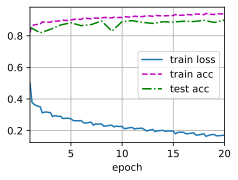

In [17]:
lr, num_epochs, batch_size = 0.3, 20, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

拉伸参数 gamma 和偏移参数 beta

In [18]:
net[1].gamma.reshape((-1,)),net[1].beta.reshape((-1,))

(tensor([2.2759, 2.2438, 2.0865, 1.7926, 2.6088, 4.4582], device='cuda:0',
        grad_fn=<ReshapeAliasBackward0>),
 tensor([-0.6189, -0.8144,  1.2821, -0.1142,  0.8420, -4.8753], device='cuda:0',
        grad_fn=<ReshapeAliasBackward0>))

调包简明实现

In [ ]:
# 调包不用传入num_dim
net = nn.Sequential(
                    nn.Conv2d(1, 6, kernel_size=5), 
                    #channel 6 / CNN :num_dim 4
                    nn.BatchNorm2d(6),
                    nn.Sigmoid(), 
                    nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(6, 16,kernel_size=5), 
                    nn.BatchNorm2d(16),
                    nn.Sigmoid(), 
                    nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Flatten(), 
                    nn.Linear(16 * 4 * 4, 120),
                    nn.BatchNorm1d(120),
                    nn.Sigmoid(),
                    nn.Linear(120, 84), 
                    nn.BatchNorm1d(84),
                    nn.Sigmoid(), 
                    nn.Linear(84, 10))

使用相同超参数来训练模型

loss 0.158, train acc 0.941, test acc 0.890
10665.5 examples/sec on cuda:0


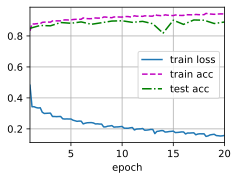

In [19]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())